# Colocalization Analysis Visualization

This notebook demonstrates the colocalization analysis approach used in SPIMquant.
We'll create toy regionprops data for two stains (Abeta and Iba1) and visualize:

1. Raw object data in 2D space
2. KDTree spatial indexing structure
3. Nearest neighbor search with distance calculations
4. Overlap ratio computation
5. Colocalization results and statistics

This visualization helps understand the spatial analysis pipeline for quantifying colocalization between different pathological markers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import KDTree
from matplotlib.patches import Circle, FancyBboxPatch
from matplotlib.collections import PatchCollection

# Set style for better-looking plots
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

## 1. Generate Toy Regionprops Data

We'll create synthetic data mimicking real regionprops output:
- **Abeta (Beta-amyloid)**: Protein plaques often found in clusters
- **Iba1**: Microglial marker, cells that often cluster around pathology

Each object has:
- Position (pos_x, pos_y)
- Size (nvoxels)
- Unique object ID
- Stain label

In [29]:
# Set seed for reproducibility
np.random.seed(42)

# Generate Abeta plaques (magenta) - clustered in certain regions
n_abeta = 300
# Create 3 clusters of Abeta
cluster_centers_abeta = np.array([[30, 40], [70, 20], [50, 70]])
abeta_positions = []
for center in cluster_centers_abeta:
    cluster_size = n_abeta // 3
    cluster_pos = center + np.random.randn(cluster_size, 2) * 8
    abeta_positions.append(cluster_pos)
abeta_positions = np.vstack(abeta_positions)

# Generate varying sizes for Abeta objects
abeta_nvoxels = np.random.lognormal(mean=10, sigma=0.8, size=n_abeta).astype(int) * 100

# Create Abeta dataframe
df_abeta = pd.DataFrame({
    'stain': 'Abeta',
    'pos_x': abeta_positions[:, 0],
    'pos_y': abeta_positions[:, 1],
    'nvoxels': abeta_nvoxels,
    'object_id': [f'Abeta_{i}' for i in range(n_abeta)]
})

# Generate Iba1 microglia (yellow) - some near Abeta, some distributed
n_iba1 = 400
# Half the Iba1 cells cluster near Abeta plaques
n_near = n_iba1 // 2
# Select random Abeta positions to cluster around
near_indices = np.random.choice(len(abeta_positions), n_near, replace=True)
iba1_near = abeta_positions[near_indices] + np.random.randn(n_near, 2) * 3

# Other half are randomly distributed
n_random = n_iba1 - n_near
iba1_random = np.random.rand(n_random, 2) * 100

iba1_positions = np.vstack([iba1_near, iba1_random])

# Iba1 cells are typically smaller than plaques
iba1_nvoxels = np.random.lognormal(mean=12, sigma=0.6, size=n_iba1).astype(int) * 50

# Create Iba1 dataframe
df_iba1 = pd.DataFrame({
    'stain': 'Iba1',
    'pos_x': iba1_positions[:, 0],
    'pos_y': iba1_positions[:, 1],
    'nvoxels': iba1_nvoxels,
    'object_id': [f'Iba1_{i}' for i in range(n_iba1)]
})

# Combine into single dataframe
df_regionprops = pd.concat([df_abeta, df_iba1], ignore_index=True)

# Calculate radius from nvoxels (assuming spherical objects)
def estimate_radius_from_nvoxels(nvoxels, voxel_size=0.01):
    """Estimate radius from number of voxels assuming spherical shape.
    
    Note: This formula assumes perfect spherical objects for simplicity. In reality,
    biological objects (plaques, cells) are typically irregular and non-spherical.
    This approximation is sufficient for colocalization analysis as it provides a
    consistent measure of object size for distance and overlap calculations.
    
    Using voxel_size=0.01 for visualization purposes to create reasonable circle
    sizes in the coordinate space (0-100). In real SPIMquant analysis, voxel_size
    would be the actual physical voxel dimension (e.g., 0.002 mm).
    """
    volume = nvoxels * (voxel_size**3)
    radius = np.cbrt((3 * volume) / (4 * np.pi))
    return radius

df_abeta['radius'] = estimate_radius_from_nvoxels(df_abeta['nvoxels'].values)
df_iba1['radius'] = estimate_radius_from_nvoxels(df_iba1['nvoxels'].values)
df_regionprops['radius'] = estimate_radius_from_nvoxels(df_regionprops['nvoxels'].values)

print(f"Generated {len(df_abeta)} Abeta objects and {len(df_iba1)} Iba1 objects")
print(f"\nSample data:")
print(df_regionprops.head(10))
print(f"\nSummary statistics:")
print(df_regionprops.groupby('stain')[['nvoxels', 'radius']].describe())

Generated 300 Abeta objects and 400 Iba1 objects

Sample data:
   stain      pos_x      pos_y  nvoxels object_id    radius
0  Abeta  33.973713  38.893886  4035900   Abeta_0  0.987682
1  Abeta  35.181508  52.184239  1053200   Abeta_1  0.631162
2  Abeta  28.126773  38.126904  4416400   Abeta_2  1.017794
3  Abeta  42.633703  46.139478  6515400   Abeta_3  1.158646
4  Abeta  26.244205  44.340480  3066100   Abeta_4  0.901224
5  Abeta  26.292658  36.274162  9885700   Abeta_5  1.331393
6  Abeta  31.935698  24.693758  1186000   Abeta_6  0.656647
7  Abeta  16.200657  35.501700   813700   Abeta_7  0.579151
8  Abeta  21.897351  42.513979   530800   Abeta_8  0.502282
9  Abeta  22.735807  28.701570  7289900   Abeta_9  1.202849

Summary statistics:
      nvoxels                                                               \
        count          mean           std        min        25%        50%   
stain                                                                        
Abeta   300.0  3.24703

## 2. Visualize Raw Object Data

Let's visualize both stains in 2D space:
- **Magenta circles**: Abeta plaques
- **Yellow circles with black outline**: Iba1 microglia

Circle sizes are proportional to object radius.

/localscratch/tmp/ipykernel_195923/1289751999.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = Circle(


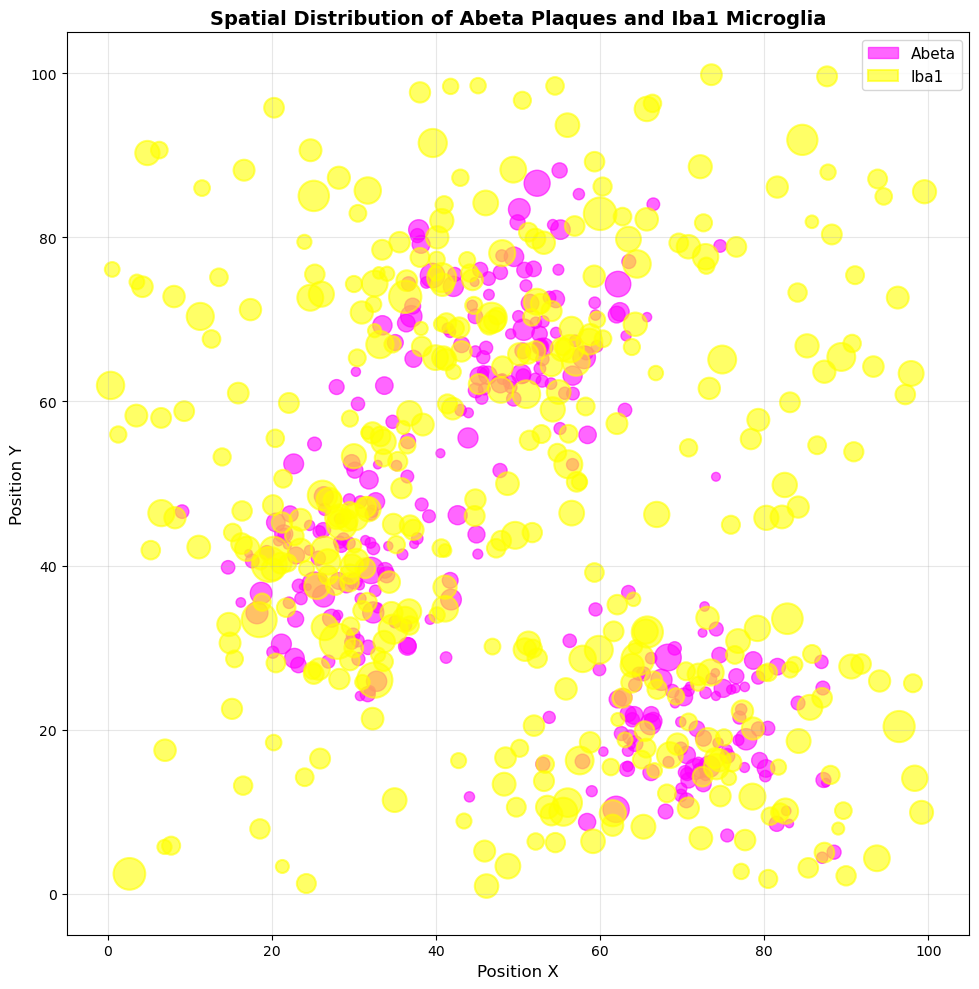


Notice: Some Iba1 microglia (yellow) cluster near Abeta plaques (magenta),
while others are distributed throughout the tissue.


In [38]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Abeta objects (magenta)
for _, obj in df_abeta.iterrows():
    circle = Circle(
        (obj['pos_x'], obj['pos_y']),
        obj['radius'],
        color='magenta',
        alpha=0.6,
        label='Abeta' if _ == 0 else ''
    )
    ax.add_patch(circle)

# Plot Iba1 objects (yellow with black outline)
for _, obj in df_iba1.iterrows():
    circle = Circle(
        (obj['pos_x'], obj['pos_y']),
        obj['radius'],
        color='yellow',
        alpha=0.6,
        edgecolor='black',
        linewidth=1.5,
        label='Iba1' if _ == 0 else ''
    )
    ax.add_patch(circle)

ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)
ax.set_aspect('equal')
ax.set_xlabel('Position X', fontsize=12)
ax.set_ylabel('Position Y', fontsize=12)
ax.set_title('Spatial Distribution of Abeta Plaques and Iba1 Microglia', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

print(f"\nNotice: Some Iba1 microglia (yellow) cluster near Abeta plaques (magenta),")
print(f"while others are distributed throughout the tissue.")

## 3. KDTree Spatial Indexing

The KDTree is a space-partitioning data structure that enables efficient nearest neighbor searches.
Instead of checking all N objects (O(N) complexity), KDTree reduces this to O(log N).

For colocalization analysis:
1. Build a KDTree for one stain (e.g., Iba1)
2. For each Abeta object, query the tree to find nearby Iba1 objects
3. Only objects within a search radius are considered

Let's visualize the search process for a few example Abeta objects.

In [31]:
# Extract coordinates for each stain
coords_abeta = df_abeta[['pos_x', 'pos_y']].values
coords_iba1 = df_iba1[['pos_x', 'pos_y']].values

# Build KDTree for Iba1 objects
tree_iba1 = KDTree(coords_iba1)

print(f"Built KDTree with {len(coords_iba1)} Iba1 objects")
print(f"Tree structure allows O(log N) search complexity instead of O(N)")

Built KDTree with 400 Iba1 objects
Tree structure allows O(log N) search complexity instead of O(N)


## 4. Nearest Neighbor Search with Distance

For each Abeta object, we:
1. Define a search radius = radius_abeta × search_radius_multiplier
2. Query the KDTree to find all Iba1 objects within this radius
3. Calculate the Euclidean distance between centroids

The `search_radius_multiplier` (default: 3.0 in SPIMquant) controls how far to search:
- Smaller values (1.0-2.0): Only very close objects
- Larger values (3.0-5.0): More permissive search

Let's visualize this for a few example Abeta objects.

/localscratch/tmp/ipykernel_195923/3934949681.py:47: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = Circle(


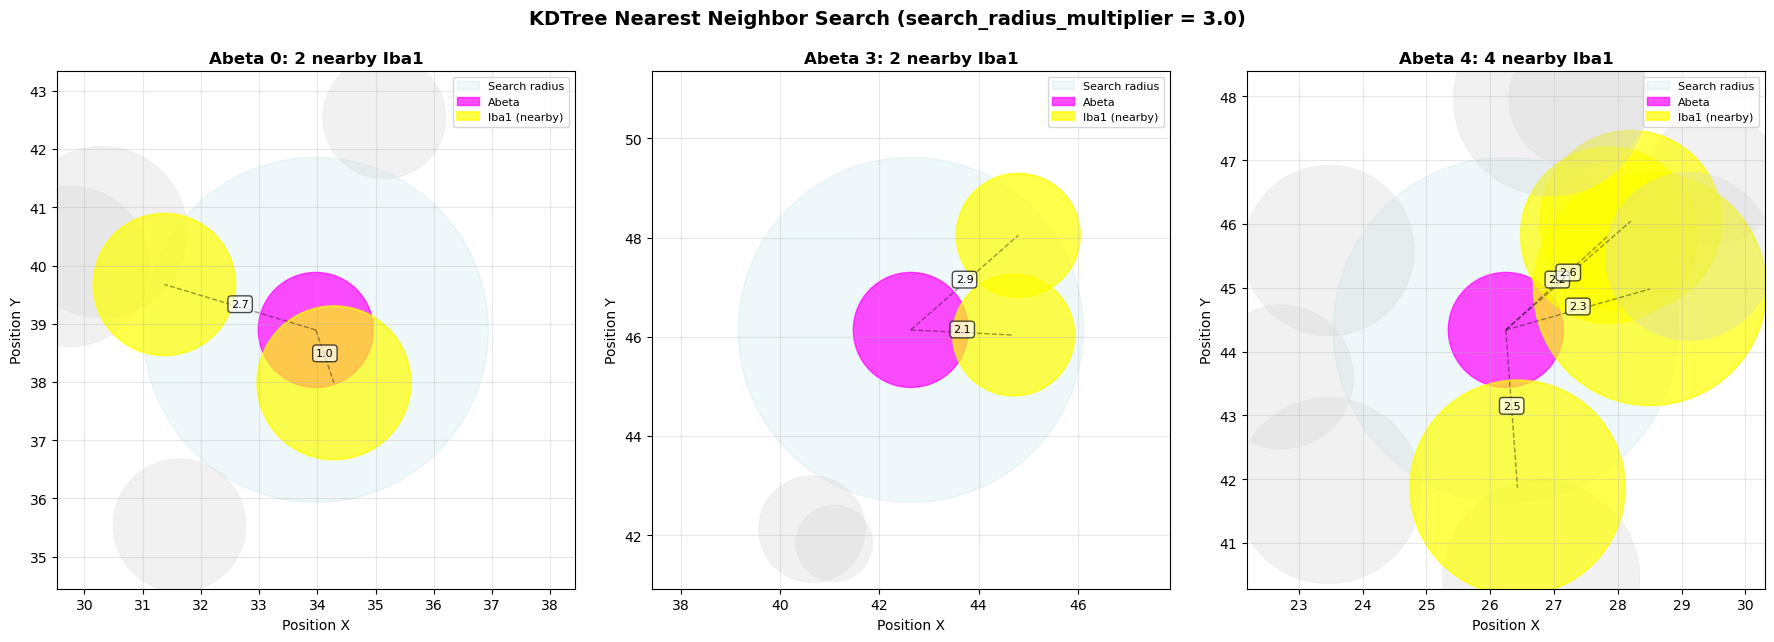


Search radius = object_radius × 3.0
Only Iba1 objects within the search radius (light blue circle) are considered.
Dashed lines show distances between centroids.


In [32]:
# Pick 3 interesting Abeta objects to demonstrate search
# Choose ones with different scenarios: isolated, near one, near multiple
example_indices = [0,3,4] 
search_radius_multiplier = 3.0

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax_idx, abeta_idx in enumerate(example_indices):
    ax = axes[ax_idx]
    
    # Get the Abeta object
    obj_abeta = df_abeta.iloc[abeta_idx]
    pos_abeta = coords_abeta[abeta_idx]
    radius_abeta = obj_abeta['radius']
    
    # Define search radius
    search_radius = radius_abeta * search_radius_multiplier
    
    # Query KDTree for nearby Iba1 objects
    indices_nearby = tree_iba1.query_ball_point(pos_abeta, r=search_radius)
    
    # Plot search radius circle (light blue)
    search_circle = Circle(
        pos_abeta,
        search_radius,
        color='lightblue',
        alpha=0.2,
        label='Search radius'
    )
    ax.add_patch(search_circle)
    
    # Plot the Abeta object
    abeta_circle = Circle(
        pos_abeta,
        radius_abeta,
        color='magenta',
        alpha=0.7,
        label='Abeta'
    )
    ax.add_patch(abeta_circle)
    
    # Plot all Iba1 objects in view (faded)
    view_range = search_radius * 1.5
    for i, pos in enumerate(coords_iba1):
        if np.linalg.norm(pos - pos_abeta) < view_range:
            is_nearby = i in indices_nearby
            circle = Circle(
                pos,
                df_iba1.iloc[i]['radius'],
                color='yellow' if is_nearby else 'lightgray',
                alpha=0.7 if is_nearby else 0.3,
                edgecolor='black' if is_nearby else 'gray',
                linewidth=1.5 if is_nearby else 0.5,
                label='Iba1 (nearby)' if is_nearby and i == indices_nearby[0] else (
                    'Iba1 (far)' if not is_nearby and i == 0 else '')
            )
            ax.add_patch(circle)
    
    # Draw distance lines to nearby Iba1 objects
    for i in indices_nearby:
        pos_iba1 = coords_iba1[i]
        distance = np.linalg.norm(pos_abeta - pos_iba1)
        ax.plot([pos_abeta[0], pos_iba1[0]], [pos_abeta[1], pos_iba1[1]], 
                'k--', alpha=0.4, linewidth=1)
        # Add distance label
        mid_point = (pos_abeta + pos_iba1) / 2
        ax.text(mid_point[0], mid_point[1], f'{distance:.1f}', 
                fontsize=8, ha='center', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    ax.set_xlim(pos_abeta[0] - view_range, pos_abeta[0] + view_range)
    ax.set_ylim(pos_abeta[1] - view_range, pos_abeta[1] + view_range)
    ax.set_aspect('equal')
    ax.set_xlabel('Position X')
    ax.set_ylabel('Position Y')
    ax.set_title(f'Abeta {abeta_idx}: {len(indices_nearby)} nearby Iba1', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)

fig.suptitle('KDTree Nearest Neighbor Search (search_radius_multiplier = 3.0)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nSearch radius = object_radius × {search_radius_multiplier}")
print(f"Only Iba1 objects within the search radius (light blue circle) are considered.")
print(f"Dashed lines show distances between centroids.")

## 5. Overlap Ratio Calculation

For each pair of nearby objects, we compute an **overlap ratio**:

```
overlap_ratio = max(0, 1 - distance / (radius_a + radius_b))
```

This metric indicates how much the objects overlap:
- **overlap_ratio = 1.0**: Objects completely overlap (distance = 0)
- **overlap_ratio = 0.5**: Objects touch at edges (distance = sum_radii/2)
- **overlap_ratio = 0.0**: Objects just touching or further (distance ≥ sum_radii)

The `overlap_threshold` parameter (default: 0.0) determines which pairs to keep:
- 0.0: Keep all pairs within search radius
- 0.5: Only keep pairs with significant overlap

Let's visualize different overlap scenarios.

/localscratch/tmp/ipykernel_195923/602260830.py:28: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle_b = Circle(pos_b, radius_b, color='yellow', alpha=0.5,


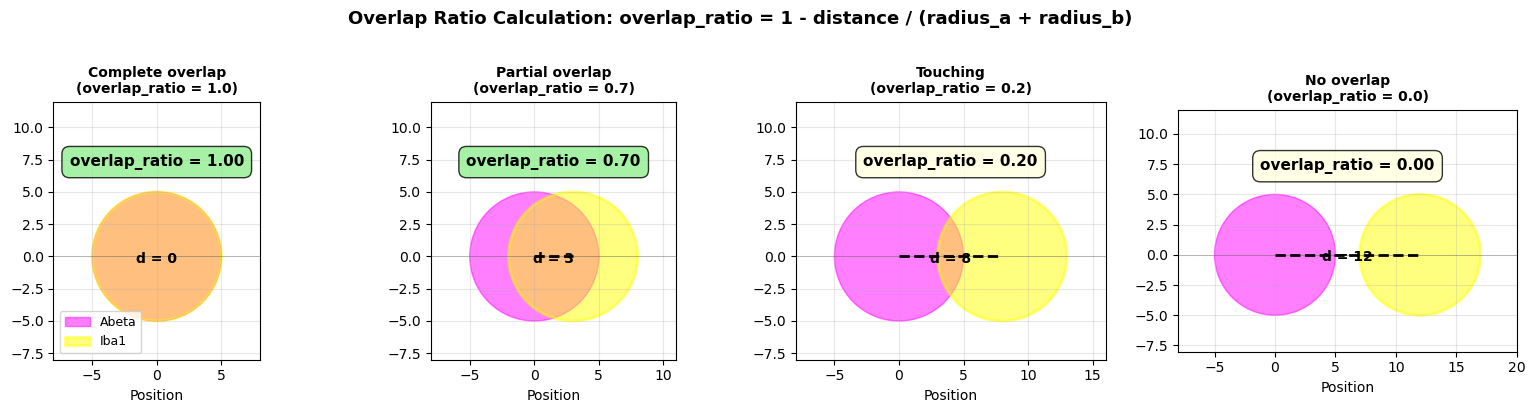


Formula: overlap_ratio = max(0, 1 - distance / (radius_a + radius_b))

With radius_a = 5 and radius_b = 5:
  sum_radii = 10
  Objects overlap when distance < 10


In [33]:
# Create illustration of different overlap scenarios
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

scenarios = [
    {'distance': 0, 'label': 'Complete overlap\n(overlap_ratio = 1.0)'},
    {'distance': 3, 'label': 'Partial overlap\n(overlap_ratio = 0.7)'},
    {'distance': 8, 'label': 'Touching\n(overlap_ratio = 0.2)'},
    {'distance': 12, 'label': 'No overlap\n(overlap_ratio = 0.0)'}
]

radius_a = 5
radius_b = 5
sum_radii = radius_a + radius_b

for ax_idx, scenario in enumerate(scenarios):
    ax = axes[ax_idx]
    distance = scenario['distance']
    
    # Calculate overlap ratio
    overlap_ratio = max(0, 1 - (distance / sum_radii))
    
    # Position objects
    pos_a = np.array([0, 0])
    pos_b = np.array([distance, 0])
    
    # Plot objects
    circle_a = Circle(pos_a, radius_a, color='magenta', alpha=0.5, label='Abeta')
    circle_b = Circle(pos_b, radius_b, color='yellow', alpha=0.5, 
                     edgecolor='black', linewidth=2, label='Iba1')
    ax.add_patch(circle_a)
    ax.add_patch(circle_b)
    
    # Draw distance line
    ax.plot([pos_a[0], pos_b[0]], [pos_a[1], pos_b[1]], 'k--', linewidth=2)
    ax.text((pos_a[0] + pos_b[0])/2, -0.5, f'd = {distance}', 
            ha='center', fontsize=10, fontweight='bold')
    
    # Add overlap ratio text
    ax.text(distance/2, 7, f'overlap_ratio = {overlap_ratio:.2f}', 
            ha='center', fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen' if overlap_ratio > 0.5 else 'lightyellow', alpha=0.8))
    
    ax.set_xlim(-8, distance + 8)
    ax.set_ylim(-8, 12)
    ax.set_aspect('equal')
    ax.set_xlabel('Position')
    ax.set_title(scenario['label'], fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linewidth=0.5, alpha=0.3)
    if ax_idx == 0:
        ax.legend(loc='lower left', fontsize=9)

fig.suptitle('Overlap Ratio Calculation: overlap_ratio = 1 - distance / (radius_a + radius_b)', 
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nFormula: overlap_ratio = max(0, 1 - distance / (radius_a + radius_b))")
print(f"\nWith radius_a = {radius_a} and radius_b = {radius_b}:")
print(f"  sum_radii = {sum_radii}")
print(f"  Objects overlap when distance < {sum_radii}")

## 6. Complete Colocalization Analysis

Now let's perform the full colocalization analysis on our toy data,
following the same algorithm used in `spimquant/workflow/scripts/compute_colocalization.py`.

In [34]:
# Perform complete colocalization analysis
search_radius_multiplier = 3.0
overlap_threshold = 0.0

coloc_results = []

# For each Abeta object, find nearby Iba1 objects
for idx_a in range(len(df_abeta)):
    obj_a = df_abeta.iloc[idx_a]
    pos_a = coords_abeta[idx_a]
    radius_a = obj_a['radius']
    
    # Define search distance
    search_distance = radius_a * search_radius_multiplier
    
    # Query KDTree for nearby Iba1 objects
    indices = tree_iba1.query_ball_point(pos_a, r=search_distance)
    
    # Process each nearby Iba1 object
    for idx_b in indices:
        obj_b = df_iba1.iloc[idx_b]
        pos_b = coords_iba1[idx_b]
        radius_b = obj_b['radius']
        
        # Calculate distance between centroids
        distance = np.linalg.norm(pos_a - pos_b)
        
        # Calculate overlap ratio
        sum_radii = radius_a + radius_b
        if sum_radii == 0:
            overlap_ratio = 0.0
        else:
            overlap_ratio = max(0, 1 - (distance / sum_radii))
        
        # Only record if overlap exceeds threshold
        if overlap_ratio > overlap_threshold:
            # Calculate colocalization coordinate (midpoint)
            coloc_coord = (pos_a + pos_b) / 2.0
            
            coloc_results.append({
                'object_id_a': obj_a['object_id'],
                'object_id_b': obj_b['object_id'],
                'stain_a': 'Abeta',
                'stain_b': 'Iba1',
                'radius_a': radius_a,
                'radius_b': radius_b,
                'nvoxels_a': obj_a['nvoxels'],
                'nvoxels_b': obj_b['nvoxels'],
                'distance': distance,
                'overlap_ratio': overlap_ratio,
                'coloc_x': coloc_coord[0],
                'coloc_y': coloc_coord[1]
            })

# Create colocalization dataframe
df_coloc = pd.DataFrame(coloc_results)

print(f"Colocalization analysis complete:")
print(f"  Total Abeta objects: {len(df_abeta)}")
print(f"  Total Iba1 objects: {len(df_iba1)}")
print(f"  Colocalized pairs found: {len(df_coloc)}")
print(f"  Average distance: {df_coloc['distance'].mean():.2f}")
print(f"  Average overlap ratio: {df_coloc['overlap_ratio'].mean():.3f}")
print(f"\nSample colocalization results:")
print(df_coloc.head())

Colocalization analysis complete:
  Total Abeta objects: 300
  Total Iba1 objects: 400
  Colocalized pairs found: 405
  Average distance: 1.46
  Average overlap ratio: 0.336

Sample colocalization results:
  object_id_a object_id_b stain_a stain_b  radius_a  radius_b  nvoxels_a  \
0     Abeta_0     Iba1_47   Abeta    Iba1  0.987682  1.316661    4035900   
1     Abeta_1    Iba1_135   Abeta    Iba1  0.631162  1.162263    1053200   
2     Abeta_2      Iba1_7   Abeta    Iba1  1.017794  1.162954    4416400   
3     Abeta_2     Iba1_61   Abeta    Iba1  1.017794  1.119511    4416400   
4     Abeta_2     Iba1_30   Abeta    Iba1  1.017794  1.194022    4416400   

   nvoxels_b  distance  overlap_ratio    coloc_x    coloc_y  
0    9561150  0.960061       0.583369  34.129797  38.439940  
1    6576600  0.533487       0.702532  35.257312  52.439985  
2    6588350  1.457992       0.331426  27.488294  38.478727  
3    5877250  0.725698       0.660461  27.919427  37.829134  
4    7130600  1.594244     

## 7. Visualize Colocalization Results

Let's create several visualizations to understand the colocalization patterns:
1. Spatial map showing all colocalized pairs
2. Distance distribution histogram
3. Overlap ratio distribution
4. Scatter plot of distance vs overlap ratio

/localscratch/tmp/ipykernel_195923/2409090635.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = Circle(


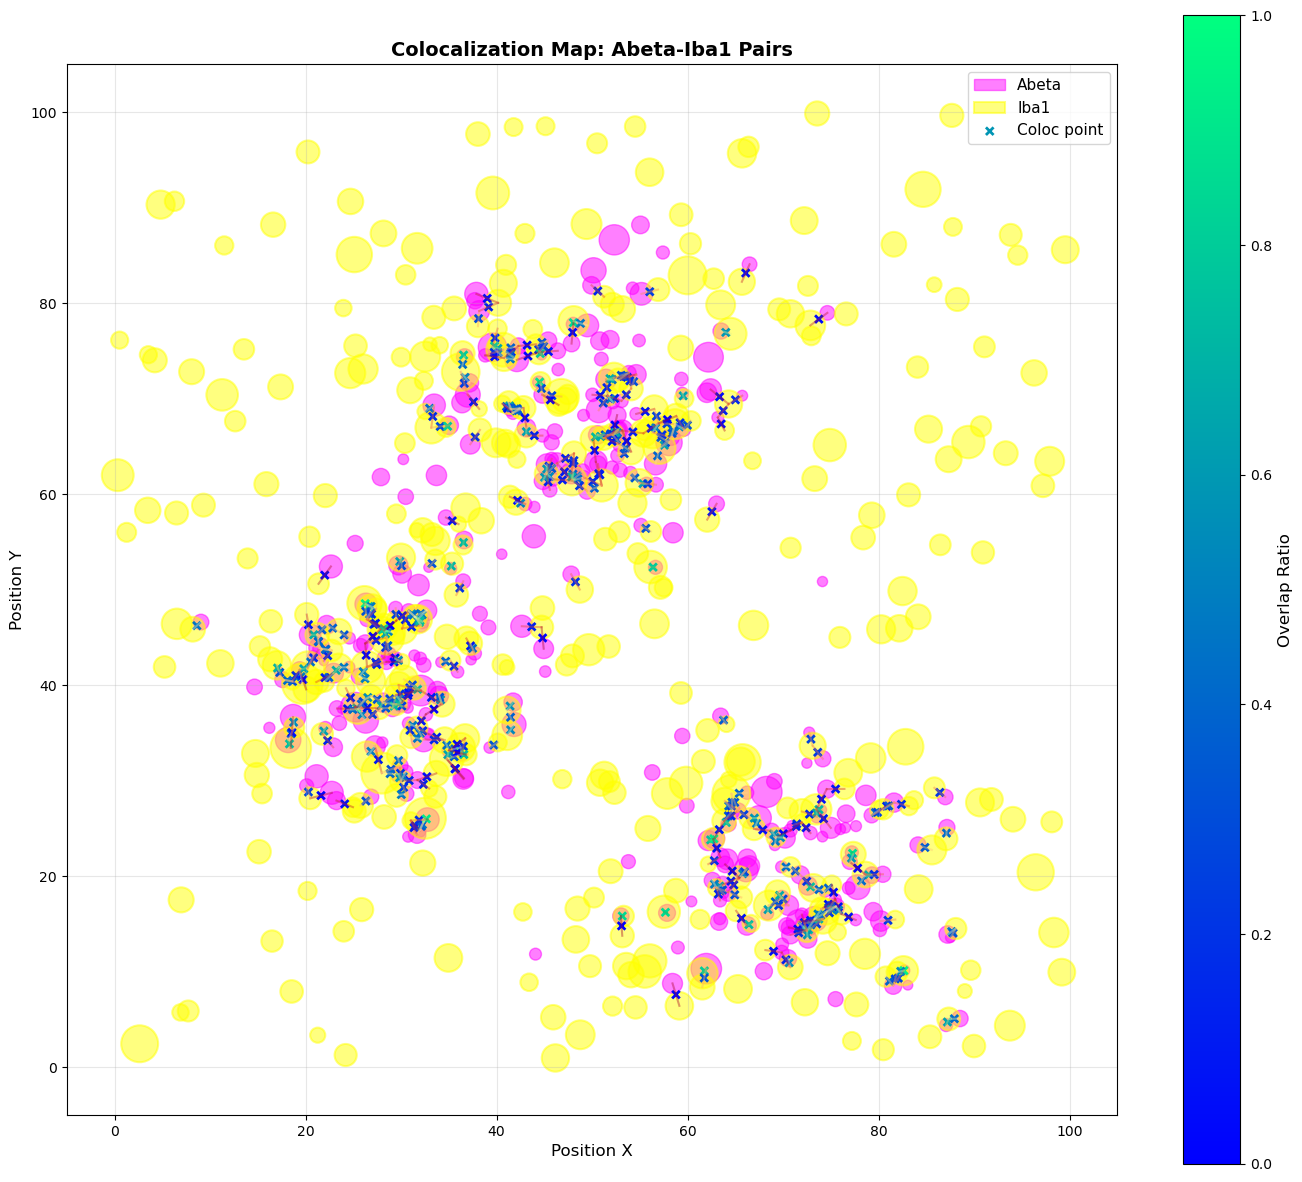


Lines connect colocalized pairs, colored by overlap ratio.
X marks show the midpoint (colocalization coordinate).


In [35]:
# 1. Spatial map with colocalization links
fig, ax = plt.subplots(figsize=(14, 12))

# Plot all Abeta objects
for _, obj in df_abeta.iterrows():
    circle = Circle(
        (obj['pos_x'], obj['pos_y']),
        obj['radius'],
        color='magenta',
        alpha=0.5,
        label='Abeta' if _ == 0 else ''
    )
    ax.add_patch(circle)

# Plot all Iba1 objects
for _, obj in df_iba1.iterrows():
    circle = Circle(
        (obj['pos_x'], obj['pos_y']),
        obj['radius'],
        color='yellow',
        alpha=0.5,
        edgecolor='black',
        linewidth=1.5,
        label='Iba1' if _ == 0 else ''
    )
    ax.add_patch(circle)

# Draw lines for colocalized pairs, colored by overlap ratio
for _, pair in df_coloc.iterrows():
    # Get positions from original dataframes
    obj_a = df_abeta[df_abeta['object_id'] == pair['object_id_a']].iloc[0]
    obj_b = df_iba1[df_iba1['object_id'] == pair['object_id_b']].iloc[0]
    
    # Color by overlap ratio
    color = plt.cm.RdYlGn(pair['overlap_ratio'])
    ax.plot([obj_a['pos_x'], obj_b['pos_x']], 
            [obj_a['pos_y'], obj_b['pos_y']], 
            color=color, alpha=0.4, linewidth=1.5)

# Plot colocalization coordinates
ax.scatter(df_coloc['coloc_x'], df_coloc['coloc_y'], 
          c=df_coloc['overlap_ratio'], cmap='winter', 
          s=30, marker='x', linewidths=2,
          label='Coloc point', vmin=0, vmax=1)

cbar = plt.colorbar(ax.collections[-1], ax=ax)
cbar.set_label('Overlap Ratio', fontsize=12)

ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)
ax.set_aspect('equal')
ax.set_xlabel('Position X', fontsize=12)
ax.set_ylabel('Position Y', fontsize=12)
ax.set_title('Colocalization Map: Abeta-Iba1 Pairs', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

print(f"\nLines connect colocalized pairs, colored by overlap ratio.")
print(f"X marks show the midpoint (colocalization coordinate).")

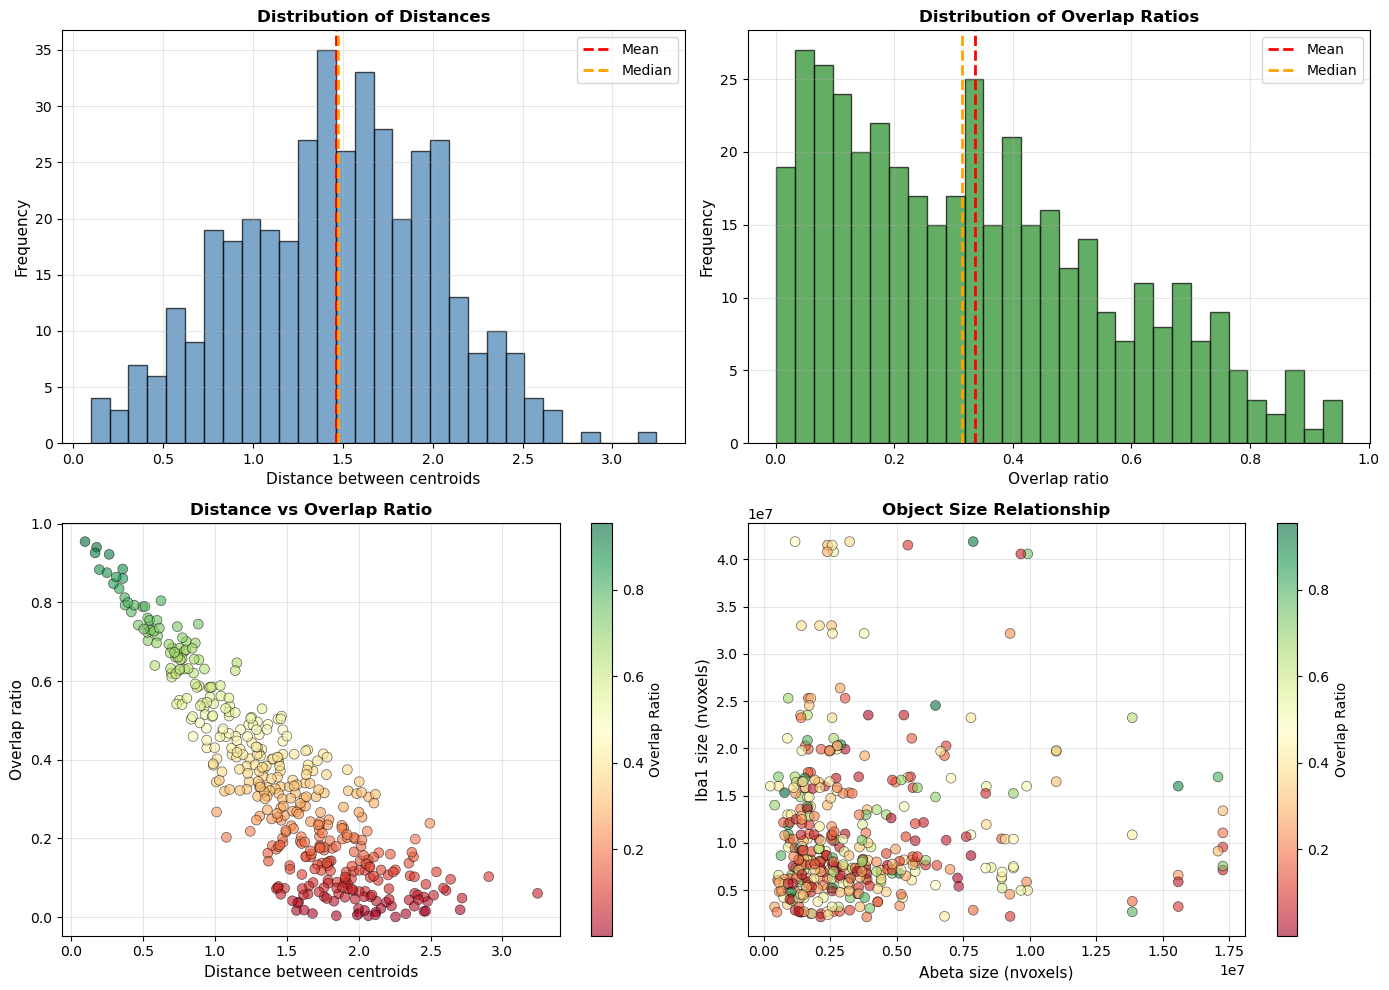


Key observations:
  - Mean distance: 1.46
  - Mean overlap ratio: 0.336
  - Pairs with overlap_ratio > 0.5: 100
  - Pairs with overlap_ratio > 0.2: 261


In [36]:
# 2-4. Distribution plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distance distribution
ax = axes[0, 0]
ax.hist(df_coloc['distance'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(df_coloc['distance'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.axvline(df_coloc['distance'].median(), color='orange', linestyle='--', linewidth=2, label='Median')
ax.set_xlabel('Distance between centroids', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Distribution of Distances', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Overlap ratio distribution
ax = axes[0, 1]
ax.hist(df_coloc['overlap_ratio'], bins=30, color='forestgreen', alpha=0.7, edgecolor='black')
ax.axvline(df_coloc['overlap_ratio'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.axvline(df_coloc['overlap_ratio'].median(), color='orange', linestyle='--', linewidth=2, label='Median')
ax.set_xlabel('Overlap ratio', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Distribution of Overlap Ratios', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Distance vs Overlap ratio scatter
ax = axes[1, 0]
scatter = ax.scatter(df_coloc['distance'], df_coloc['overlap_ratio'], 
                    c=df_coloc['overlap_ratio'], cmap='RdYlGn', 
                    s=50, alpha=0.6, edgecolors='black', linewidths=0.5)
ax.set_xlabel('Distance between centroids', fontsize=11)
ax.set_ylabel('Overlap ratio', fontsize=11)
ax.set_title('Distance vs Overlap Ratio', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Overlap Ratio')

# Object size relationship
ax = axes[1, 1]
scatter = ax.scatter(df_coloc['nvoxels_a'], df_coloc['nvoxels_b'],
                    c=df_coloc['overlap_ratio'], cmap='RdYlGn',
                    s=50, alpha=0.6, edgecolors='black', linewidths=0.5)
ax.set_xlabel('Abeta size (nvoxels)', fontsize=11)
ax.set_ylabel('Iba1 size (nvoxels)', fontsize=11)
ax.set_title('Object Size Relationship', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Overlap Ratio')

plt.tight_layout()
plt.show()

print("\nKey observations:")
print(f"  - Mean distance: {df_coloc['distance'].mean():.2f}")
print(f"  - Mean overlap ratio: {df_coloc['overlap_ratio'].mean():.3f}")
print(f"  - Pairs with overlap_ratio > 0.5: {(df_coloc['overlap_ratio'] > 0.5).sum()}")
print(f"  - Pairs with overlap_ratio > 0.2: {(df_coloc['overlap_ratio'] > 0.2).sum()}")

## 8. Summary Statistics

Let's compute some summary statistics about the colocalization analysis.

In [37]:
# Compute summary statistics
print("=" * 70)
print("COLOCALIZATION ANALYSIS SUMMARY")
print("=" * 70)
print(f"\nInput objects:")
print(f"  Abeta plaques: {len(df_abeta)}")
print(f"  Iba1 microglia: {len(df_iba1)}")
print(f"\nSearch parameters:")
print(f"  Search radius multiplier: {search_radius_multiplier}")
print(f"  Overlap threshold: {overlap_threshold}")
print(f"\nColocalization results:")
print(f"  Total pairs found: {len(df_coloc)}")
print(f"  Abeta objects with ≥1 Iba1: {df_coloc['object_id_a'].nunique()} ({df_coloc['object_id_a'].nunique()/len(df_abeta)*100:.1f}%)")
print(f"  Iba1 objects with ≥1 Abeta: {df_coloc['object_id_b'].nunique()} ({df_coloc['object_id_b'].nunique()/len(df_iba1)*100:.1f}%)")
print(f"  Avg pairs per Abeta: {len(df_coloc)/len(df_abeta):.2f}")
print(f"  Avg pairs per Iba1: {len(df_coloc)/len(df_iba1):.2f}")
print(f"\nDistance statistics:")
print(f"  Mean: {df_coloc['distance'].mean():.3f}")
print(f"  Median: {df_coloc['distance'].median():.3f}")
print(f"  Std: {df_coloc['distance'].std():.3f}")
print(f"  Min: {df_coloc['distance'].min():.3f}")
print(f"  Max: {df_coloc['distance'].max():.3f}")
print(f"\nOverlap ratio statistics:")
print(f"  Mean: {df_coloc['overlap_ratio'].mean():.3f}")
print(f"  Median: {df_coloc['overlap_ratio'].median():.3f}")
print(f"  Std: {df_coloc['overlap_ratio'].std():.3f}")
print(f"  Min: {df_coloc['overlap_ratio'].min():.3f}")
print(f"  Max: {df_coloc['overlap_ratio'].max():.3f}")
print(f"\nOverlap ratio thresholds:")
for threshold in [0.1, 0.2, 0.3, 0.5, 0.7]:
    count = (df_coloc['overlap_ratio'] >= threshold).sum()
    pct = count / len(df_coloc) * 100
    print(f"  overlap_ratio ≥ {threshold}: {count} pairs ({pct:.1f}%)")
print("=" * 70)

COLOCALIZATION ANALYSIS SUMMARY

Input objects:
  Abeta plaques: 300
  Iba1 microglia: 400

Search parameters:
  Search radius multiplier: 3.0
  Overlap threshold: 0.0

Colocalization results:
  Total pairs found: 405
  Abeta objects with ≥1 Iba1: 225 (75.0%)
  Iba1 objects with ≥1 Abeta: 182 (45.5%)
  Avg pairs per Abeta: 1.35
  Avg pairs per Iba1: 1.01

Distance statistics:
  Mean: 1.463
  Median: 1.472
  Std: 0.558
  Min: 0.096
  Max: 3.244

Overlap ratio statistics:
  Mean: 0.336
  Median: 0.314
  Std: 0.232
  Min: 0.001
  Max: 0.954

Overlap ratio thresholds:
  overlap_ratio ≥ 0.1: 330 pairs (81.5%)
  overlap_ratio ≥ 0.2: 261 pairs (64.4%)
  overlap_ratio ≥ 0.3: 214 pairs (52.8%)
  overlap_ratio ≥ 0.5: 100 pairs (24.7%)
  overlap_ratio ≥ 0.7: 35 pairs (8.6%)


## 9. Conclusion

This notebook demonstrated the key steps in SPIMquant's colocalization analysis:

1. **Data Representation**: Objects are represented by their centroid positions and sizes
2. **KDTree Indexing**: Enables efficient spatial queries in O(log N) time
3. **Nearest Neighbor Search**: Finds potential colocalization candidates within a search radius
4. **Distance Calculation**: Measures Euclidean distance between object centroids
5. **Overlap Ratio**: Quantifies the degree of spatial overlap (0 = no overlap, 1 = complete overlap)
6. **Colocalization Coordinate**: Midpoint between paired objects for downstream spatial analysis

### Key Parameters:

- **`search_radius_multiplier`** (default: 3.0): Controls how far to search
  - Lower values: Only very close pairs
  - Higher values: More permissive search

- **`overlap_threshold`** (default: 0.0): Minimum overlap to record
  - 0.0: Record all pairs within search radius
  - 0.5: Only record significant overlaps

### Applications:

This analysis enables:
- Quantifying spatial relationships between pathological markers
- Identifying microglial activation near amyloid plaques
- Creating spatial density maps of colocalization
- Statistical analysis of disease progression

### Next Steps:

The colocalization results can be further analyzed:
- Map to atlas regions for anatomical quantification
- Compute kernel density estimates (KDE) for hotspot identification
- Voxelize colocalization coordinates for 3D visualization
- Compare across experimental groups or time points